# Package Installation

## graph-tool installation

In [2]:
#on windows: 
#use the windows key
#type anaconda
#open the anaconda power prompt as ADMINISTRATOR (right click). 
#conda activate base
#conda create -n myenv python=3.8. 
#conda install -c conda-forge graph-tool


In [1]:
# check your python installation
import sys
sys.executable

'/Users/yil1/opt/anaconda3/envs/P2P/bin/python'

In [2]:
from collections import Counter

In [3]:
def install_missing_packages(package_names):
    """
    Install Missing Packages

    This function checks if a list of packages is already installed and installs any missing packages using pip.

    Parameters:
    - package_names (list): A list of package names to be installed.

    Returns:
    - None

    Note: This function requires the `subprocess` and `importlib` modules to be imported.

    Example Usage:
    install_missing_packages(['h2o', 'numpy', 'pandas'])
    """
    import importlib
    import subprocess


    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} package is already installed")
        except ImportError:
            print(f"{package_name} package not found, installing with pip...")
            subprocess.call(['pip', 'install', package_name])


In [53]:
package_list = ['python-louvain']
install_missing_packages(package_list)

python-louvain package not found, installing with pip...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=3e9120cea70d810314c26257149a33b464ffd89f0805d65598337a3d3e4695ce
  Stored in directory: /Users/yil1/Library/Caches/pip/wheels/af/40/91/ef3635f7d3ddbd889b5af9f1ac22b8d30c48d6f744cd74a6d1
Successfully built python-louvain


# Functions

## First-satge data cleaning

In [23]:
'''
clean_data(df):
This code defines a function called `clean_data`, which takes a DataFrame (usually a DataFrame object in the pandas library) as input and performs a series of data cleaning operations on it. The specific cleaning steps are as follows:

1. **Delete missing values**: Use the `dropna()` method to remove rows containing missing values.

2. **Filter specific rows**: keep the rows whose `lang.1` column is equal to 1, and reset the index.

3. **Delete 'lang' column**: Delete all columns containing "lang".

4. **Delete Date Columns**: Delete `date.start` and `date.end` columns as they are considered irrelevant.

5. **Remove Look-Bias Variables**: Define a list containing look-ahead-bias variables and use the `drop()` method to drop those columns from the DataFrame.

6. **Delete Duplicate Income Variables**: Delete all columns that contain "inc." and do not contain ".no".

7. **Delete Dummy Variables**: Defines a list of dummy variables to delete and removes these columns from the DataFrame.

8. **Generate Correlation Matrix**: Use the `corr()` method to generate the correlation matrix of DataFrame.

9. **Choose the upper triangle of the correlation matrix**: To avoid multicollinearity, select the upper triangle of the correlation matrix.

10. **Find High Correlation Columns**: Find columns that have a correlation higher than 0.95 with other columns.

11. **Delete High Correlation Columns**: Delete the high correlation columns found in step 10.

Finally, the function returns the cleaned DataFrame.

The purpose of this code is to prepare the data for subsequent analysis or modeling. It cleans data by removing missing values, filtering specific rows, removing irrelevant or biased columns, and handling multicollinearity.

'''


# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random

# Define a function to calculate variance inflation factor (VIF) for all variables in a given DataFrame.
def calculate_vif(df):
    """Calculates variance inflation factor for all columns in df. It should contain 
    only exogeneous variables."""
    
    # Create an empty DataFrame
    vif = pd.DataFrame()
    
    # Calculate VIF for every column (variable) in the DataFrame
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    # Store column names
    vif["features"] = df.columns
    
    # Sort by VIF Factor in descending order
    vif = vif.sort_values("VIF Factor", ascending=False)
    return vif

# Define a function to clean the DataFrame, removing irrelevant and problematic features.
def clean_data(df):
    """
    Clean the given DataFrame, drop unnecessary columns, handle missing data, remove biased variables, 
    avoid multicollinearity by checking correlation, and keep only relevant columns.
    """
    
    # Drop rows with missing values
    df = df.dropna().reset_index(drop=True)

    # Filter for only rows where 'lang.1' equals 1, and drop 'lang' columns
    df = df[df["lang.1"] == 1].reset_index(drop=True)
    df = df.drop([x for x in df.columns if "lang" in x], axis=1)

    # Drop date columns as they are not considered relevant
    df = df.drop(["date.start", "date.end"], axis=1)

    # List of forward-looking biased variables
    fwl_bias = [
        "return",
        "RR1",
        "RR2.Mean",
        "RR2.Median",
        "RR2.WMean",
        "NPRP",
        "NPRA",
        "FVCI",
        "FVCI.Mean",
        "FVCI.Median",
        "FVCI.WMean",
    ]
    # Drop these forward-looking biased variables
    df = df.drop(fwl_bias, axis=1)

    # Drop duplicate income variables, keep only those with '.no' in name
    df = df.drop([x for x in df.columns if "inc." in x and ".no" in x], axis=1)

    # List of dummy variables to drop
    dummies_to_drop = ["AA", "educ.6", "em.dur.5p", "use.m", "ver.2", "Mining", "Utilities"]
    df = df.drop(dummies_to_drop, axis=1)

    # Generate a correlation matrix of the DataFrame
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    # Drop these columns from the DataFrame
    df = df.drop(df[to_drop], axis=1)

    return df

def create_balanced_sample(df, n, replace = False):
    """Create a balanced sample of size 2n from df. Ensures that the sample contains an equal number of instances for each class."""
    
    # Draw a random sample of size 'n' from the non-default class (default = 0) and from the default class (default = 1)
    # replace=True allows for resampling
    # Random state ensures reproducibility
    df_sample = pd.concat(
        [
            df[df["default"] == 0].sample(n=n, random_state=1, replace=replace),
            df[df["default"] == 1].sample(n=n, random_state=1, replace=replace),
        ]
    ).reset_index(drop=True)
    
    return df_sample

import pandas as pd

def create_sample(df, n, replace=False):
    """
    Create a sample of total size 'n' from df without ensuring any balance between classes.

    Parameters:
    - df: DataFrame containing the data
    - n: Total sample size
    - replace: Whether to allow resampling

    Returns:
    A DataFrame sample of size 'n'.
    """
    
    # Draw a random sample of size 'n' from the DataFrame
    # Random state ensures reproducibility
    df_sample = df.sample(n=n, random_state=1, replace=replace).reset_index(drop=True)
    
    return df_sample

# Example usage
# df = ... (your DataFrame)
# sample_df = create_sample(df, 100)



## Pands Numpy handling

In [6]:
import pandas as pd

def convert_to_category(df):
    """
    Convert columns with exactly two unique values to category type.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to process.
        
    Returns:
        df (pandas.DataFrame): Processed DataFrame with columns converted to category type where applicable.
        category_columns (list): List of names of the columns that were converted to category type.
    """
    
    # Initialize a list to store the names of the columns converted to category type
    category_columns = []

    # Iterate through each column in the DataFrame
    for col in df.columns:
        # If the column has exactly two unique values
        if df[col].nunique() == 2:
            # Convert the column to category type
            df[col] = df[col].astype('category')
            # Append the column name to the category_columns list
            category_columns.append(col)

    return df, category_columns


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(distance_matrix, bins=50):
    # 将矩阵拉平为一维数组
    flattened_values = distance_matrix.flatten()

    # 创建直方图
    plt.figure(figsize=(10, 6)) # 设置图形大小
    plt.hist(flattened_values, bins=bins, edgecolor='k') # edgecolor 用于设置边缘颜色
    plt.title('Histogram of Distance Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# 假设 distance_matrix 是一个 32469 x 32469 的 NumPy 数组
# distance_matrix = np.random.rand(32469, 32469) # 示例


## File IO

In [8]:
import os

def generate_file_path(file_name):
    """
    Generate a file path for a file located one directory level up.

    Parameters:
    file_name (str): The name of the file including any subdirectories from the parent directory.

    Returns:
    file_path (str): The full path to the file.
    """
    # Get the current working directory
    cwd = os.getcwd()

    # Get the parent directory
    parent_dir = os.path.dirname(cwd)

    # Define the file path by joining the parent directory path with the file name
    file_path = os.path.join(parent_dir, file_name)

    return file_path


In [9]:
# function to save a pandas dataframe as csv to disc.
def save_df_to_csv(df, file_path):
    """
    This function saves a pandas DataFrame to a CSV file.

    Parameters:
    df (pandas.DataFrame): The DataFrame to save.
    file_path (str): The file path where to save the DataFrame, including the filename.

    Returns:
    None
    """
    df.to_csv(file_path, index=False)  # Set index=False to not save row indices

In [10]:
import pandas as pd

def compute_summary_stats(df, cols):
    """
    This function computes summary statistics for specified columns in a pandas dataframe.

    Args:
    df (pandas.DataFrame): The dataframe on which to compute summary statistics.
    cols (list): A list of column names for which to compute summary statistics.

    Returns:
    pandas.DataFrame: A dataframe with summary statistics for the specified columns.

    Example:
    summary_stats = compute_summary_stats(df, ['liab.I', 'inc.total', 'MonthlyPayment', 'log.amount', 'time', 'Interest', 'AmountOfPreviousLoansBeforeLoan', 'NoOfPreviousLoansBeforeLoan', 'Age'])
    print(summary_stats)
    """

    # Check if all columns exist in dataframe
    for col in cols:
        if col not in df.columns:
            print(f'Column {col} does not exist in the dataframe.')
            return None

    # Compute summary statistics
    summary_stats = df[cols].describe()

    return summary_stats

In [11]:
def df_to_latex(df):
    """
    This function converts a pandas DataFrame into a LaTeX table.

    Args:
    df (pandas.DataFrame): The dataframe to convert to LaTeX.

    Returns:
    str: A string of LaTeX code for a table with the data from the DataFrame.

    Example:
    latex_code = df_to_latex(summary_stats)
    print(latex_code)
    """

    # Convert DataFrame to LaTeX
    latex_code = df.to_latex()

    return latex_code

In [12]:
# retrieving the number of non-defaulted vs. defaulted loans
def count_defaults(df):
    """
    This function counts and prints the number of defaulted loans in a DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing the loan data. It must contain a 'default' column 
                    with binary values: 1 for default and 0 otherwise.

    Returns:
    None. The function directly prints the number of defaulted loans.
    """
    
    num_defaults = df['default'].sum()
    print(f"The number of loans that have defaulted is: {num_defaults}")

## Calculate and save gowers distance


In [13]:
import pandas as pd
import numpy as np
import gower


def calculate_and_save_gowers_distance(dataframe, output_file_path):
    """
    Calculates Gower's distance matrix for a given DataFrame and saves the result as a numpy array.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame.
    output_file_path (str): The path where the resulting numpy array should be saved.

    Returns:
    None
    """
    try:
        # Drop the 'default' column to keep only features
        dataframe = dataframe.drop(["default"], axis=1)

        # Identify dummy columns (faster for gower calculations)
        dummy_columns = [
            column for column in dataframe.columns
            if ((dataframe[column] == 0) | (dataframe[column] == 1)).all()
        ]
        categorical_variables = [
            column in dummy_columns for column in dataframe.columns
        ]

        # Calculate Gower's distance
        distance_matrix = gower.gower_matrix(
            dataframe, cat_features=categorical_variables)

        # Save the distance matrix as a numpy array
        np.save(output_file_path, distance_matrix)

        print(f"Distance matrix saved successfully at {output_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return distance_matrix


# Changes made:

# 1. Renamed the function to `calculate_and_save_gowers_distance` for clarity.
# 2. Added a try-except block to handle potential errors during execution.
# 3. Added comments to explain each step of the process.
# 4. Improved the print statement to include the output file path for better tracking.

In [14]:
import numpy as np
import pandas as pd
from graph_tool.all import *

In [15]:
def matrix_to_graph_tool(adj):
    """
    Convert adjacency matrix to graph using graph-tool.

    Parameters:
    adj (numpy.ndarray): The adjacency matrix.

    Returns:
    g (graph_tool.Graph): The graph.
    """
    # Extract index and weights from the adjacency matrix.
    # np.nonzero(np.triu(adj, 1)) returns the indices of the upper triangle of the matrix,
    # excluding the diagonal. This is because for an undirected graph, the adjacency matrix
    # is symmetric, and we only need to consider half of the matrix to get all the edges.
    idx = np.nonzero(np.triu(adj, 1))

    # Get the weights of the edges from the adjacency matrix.
    weights = adj[idx]

    # Create an empty graph.
    g = Graph()

    # Add edges to the graph. np.transpose(idx) gives a 2D array where each row is the indices
    # of the two vertices of an edge.
    g.add_edge_list(np.transpose(idx))

    # Create an edge property map for the weights of the edges.
    edge_weight = g.new_edge_property("double")

    # Assign the weights to the edge property map.
    edge_weight.a = weights

    # Add the edge property map to the graph.
    g.edge_properties["edge_weight"] = edge_weight

    return g

## Data Sampling

In [16]:
import pandas as pd
import numpy as np

def data_sampling(df_sample, train=0.6, validation=0.2, test=0.2, random_state=8):
    """
    This function calculates the row indices for train, validation, and test splits 
    based on the given proportions.

    Parameters:
    - df_sample: The input pandas DataFrame.
    - train: Proportion of data for training. Default is 0.6.
    - validation: Proportion of data for validation. Default is 0.2.
    - test: Proportion of data for testing. Default is 0.2.
    - random_state: Random seed for reproducibility. Default is 8.

    Returns:
    - train_indices: Row indices for the training split.
    - validation_indices: Row indices for the validation split.
    - test_indices: Row indices for the test split.
    """

    # Check if the input DataFrame is empty.
    if df_sample.empty:
        raise ValueError("The input DataFrame is empty!")

    # Validate if the sum of train, validation, and test proportions equals 1.
    if not (train + validation + test == 1.0):
        raise ValueError("The sum of train, validation, and test proportions should be 1.0")

    # Shuffle the row indices.
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(df_sample.index)

    # Calculate the number of rows for each split.
    total_rows = len(df_sample)
    train_end = int(total_rows * train)
    validation_end = train_end + int(total_rows * validation)

    # Split the shuffled indices based on the calculated sizes.
    train_indices = shuffled_indices[:train_end]
    validation_indices = shuffled_indices[train_end:validation_end]
    test_indices = shuffled_indices[validation_end:]

    return train_indices, validation_indices, test_indices

## MST

In [42]:
from scipy.sparse.csgraph import minimum_spanning_tree
import numpy as np

def compute_mst_distance_matrix(distance_matrix):
    """
    Computes the minimum spanning tree (MST) of a given distance matrix and returns the MST distance matrix.
    
    Parameters:
    - distance_matrix (numpy.ndarray): The original distance matrix.
    
    Returns:
    - numpy.ndarray: The MST distance matrix with the same dimensions as the input, where the non-MST edges have a distance of 0.
    """
    # Display initial status
    print("Starting the computation of the minimum spanning tree...")
    
    # Compute the minimum spanning tree using the input distance matrix
    mst_sparse = minimum_spanning_tree(distance_matrix)
    
    # Display status after MST computation
    print("Minimum spanning tree computed. Converting to dense matrix...")
    
    # Convert the sparse matrix to a dense matrix
    mst_dense = mst_sparse.toarray().astype(distance_matrix.dtype)
    
    # Display final status
    print("Conversion complete. Returning MST distance matrix.")
    
    return mst_dense

# Example usage:
# Assume distance_matrix is a 32469x32469 numpy array containing your distance values
# distance_matrix = np.load("your_file.npy")

# Compute the MST distance matrix
# mst_distance_matrix = compute_mst_distance_matrix(distance_matrix)


## Melt Matrix

In [49]:
import numpy as np

def melt_matrix(distance_matrix, keep_rows, keep_columns):
    """
    Melts the distance matrix based on specified rows and columns to keep.

    Parameters:
    - distance_matrix (numpy.ndarray): Original distance matrix.
    - keep_rows (list): List of row indices to keep.
    - keep_columns (list): List of column indices to keep.

    Returns:
    - list: A list of dictionaries, each containing three key-value pairs: 'from', 'to', and 'weight'.
    """
    # Slice the matrix to keep only the specified rows and columns
    sub_matrix = distance_matrix[np.ix_(keep_rows, keep_columns)]

    # Initialize an empty list to store the dictionaries
    melted_list = []
    
    # Populate the list with dictionaries
    for i, row_idx in enumerate(keep_rows):
        for j, col_idx in enumerate(keep_columns):
            melted_list.append({
                'from': row_idx,
                'to': col_idx,
                'weight': sub_matrix[i, j]
            })

    return melted_list

# Example usage
distance_matrix = np.array([[0, 1, 2], [1, 0, 3], [2, 3, 0]])
keep_rows = [0, 1]
keep_columns = [0, 2]

melted_list = melt_matrix(distance_matrix, keep_rows, keep_columns)
print(melted_list)


[{'from': 0, 'to': 0, 'weight': 0}, {'from': 0, 'to': 2, 'weight': 2}, {'from': 1, 'to': 0, 'weight': 1}, {'from': 1, 'to': 2, 'weight': 3}]


## Centrality Measures Calculation

In [87]:
import networkx as nx
import community as community_louvain

def compute_centrality_measures(edge_list):
    """
    This function computes various centrality and community measures for a given MultiGraph.
    
    Parameters:
    edge_list (list of dicts): List containing dictionaries with 'from', 'to', and 'weight' keys that represent the edges of the MultiGraph.
    
    Returns:
    list of lists: A list containing a header row and sublists that hold the centrality measures for each node in the graph.
    """
    
    # Initialize the MultiGraph
    G = nx.MultiGraph()
    
    # Populate the graph with edges from the edge list
    for edge in edge_list:
        G.add_edge(edge['from'], edge['to'], weight=edge['weight'])
    
    # Initialize the result list to store centrality measures for each node
    centrality_result = []
    
    # Add the header row with column names
    centrality_result.append(['node', 'pagerank', 'betweenness', 'closeness', 'authority', 'hub', 'louvain_community'])
    
    # Compute the PageRank centrality
    pr_w = nx.pagerank(G, weight='weight')
    
    # Compute the Betweenness centrality
    bw_w = nx.betweenness_centrality(G, weight='weight')
    
    # Compute the Closeness centrality
    cl_w = nx.closeness_centrality(G, distance='weight')
    
    # Compute the HITS algorithm measures: Hub and Authority
    hits_hub_w, hits_aut_w = nx.hits(G, max_iter=1000)
    
    # Compute the Louvain community detection
    partition = community_louvain.best_partition(G)
    
    # Extract nodes from the graph, sorted by their identifier
    nodes = sorted(G.nodes())
    
    # Populate the result list with computed centrality measures and community identifiers
    for node in nodes:
        centrality_result.append([
            node,
            pr_w.get(node, 0),
            bw_w.get(node, 0),
            cl_w.get(node, 0),
            hits_aut_w.get(node, 0),
            hits_hub_w.get(node, 0),
            partition.get(node, -1)
        ])
        
    return centrality_result

# Example usage
edge_list = [
    {'from': 0, 'to': 0, 'weight': 0}, 
    {'from': 0, 'to': 2, 'weight': 2}, 
    {'from': 1, 'to': 0, 'weight': 1}, 
    {'from': 1, 'to': 2, 'weight': 3}
]
result = compute_centrality_measures(edge_list)
print(result)


[['node', 'pagerank', 'betweenness', 'closeness', 'authority', 'hub', 'louvain_community'], [0, 0.25946370422022713, 2.333333333333333, 0.6666666666666666, 0.27062146128435793, 0.27062146128435777, 0], [1, 0.3319131473986592, 0.0, 0.5, 0.3456664931063332, 0.3456664931063332, 0], [2, 0.4086231483811135, 0.0, 0.4, 0.383712045609309, 0.38371204560930905, 0]]


## Data Segment

In [61]:
from sklearn.model_selection import train_test_split

def split_dataset(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Splits a dataset into training, validation, and test sets while keeping track of the indices of the positive and negative samples in the training set.

    Parameters:
    - df (DataFrame): The original dataset. The column named 'default' should contain binary labels (0 or 1).
    - train_ratio (float): The proportion of the dataset to include in the training set.
    - val_ratio (float): The proportion of the dataset to include in the validation set.
    - test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
    - train_pos_indices: List of indices corresponding to positive samples in the training set.
    - train_neg_indices: List of indices corresponding to negative samples in the training set.
    - val_indices: List of indices for the validation set.
    - test_indices: List of indices for the test set.
    """
    # Validate the input ratios
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio must be 1.")

    # Split the dataset
    test_size = test_ratio
    val_size = val_ratio / (1 - test_size)  # Adjust the validation set size based on the remaining dataset after test split
    
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=42)

    # Extract indices
    train_pos_indices = train_df[train_df['default'] == 1].index.tolist()
    train_neg_indices = train_df[train_df['default'] == 0].index.tolist()
    val_indices = val_df.index.tolist()
    test_indices = test_df.index.tolist()

    return train_pos_indices, train_neg_indices, val_indices, test_indices

# Example usage:
# Assume df is your DataFrame containing a 'default' column
# train_pos_indices, train_neg_indices, val_indices, test_indices = split_dataset(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)
# print(train_pos_indices)
# print(train_neg_indices)
# print(val_indices)
# print(test_indices)


# Data Preprocessing

Read the raw data from bondora.
Do some preprocessing
Save it as cleaned data in feather format.
Then sample a subset and save as cvs


The 1st round feature elimination happens here: Simply remove some features irrelevant to prediction.

#Load original dataset
file_path = generate_file_path("data/Bondora_feather")
print(file_path)

#Load the dataset
df = pd.read_feather(file_path)

#Clean data
df_clean = clean_data(df)

#Save cleaned data
file_path_cleaned = generate_file_path("data/Bondora_clean.feather")
df_clean.to_feather(file_path_cleaned)

In [25]:
file_path = generate_file_path("data/Bondora_clean.feather")
df_clean = pd.read_feather(file_path)

In [26]:
df_clean.shape

(32469, 155)

In [27]:
df_clean['default'].value_counts()

default
0.0    20241
1.0    12228
Name: count, dtype: int64

# Create balanced sample and save
df_sample = create_balanced_sample(df_clean, num_default_samples, replace=False)

In [28]:
df_sample = create_sample(df_clean, n=24000, replace=False)

In [29]:
#save the file
file_path_cleaned_sampled = generate_file_path("data/Bondora_sample(" +
                                               '24000' + ").feather")
df_sample.to_feather(file_path_cleaned_sampled)
print(file_path_cleaned_sampled)

/Users/yil1/p2p-model-bondora/data/Bondora_sample(24000).feather


In [30]:
# Generating data frame for the entire datasample
df_clean

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,1.0,1,30,1.0,28.00,0.000000,19.11,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
1,1.0,1,39,0.0,28.00,0.000000,45.22,0,0.0,1.845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
2,1.0,1,32,0.0,28.00,0.000000,44.86,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
3,0.0,1,27,0.0,19.00,0.000000,10.70,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
4,0.0,0,31,0.0,16.00,0.000000,15.85,1,3000.0,1.840,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32464,0.0,0,22,0.0,18.41,3.433342,0.00,5,9886.0,4.794,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32465,0.0,1,29,0.0,16.36,3.794815,0.00,1,1275.0,4.797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32466,0.0,0,32,0.0,17.12,3.684118,0.00,3,12120.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32467,0.0,0,46,1.0,25.63,5.477802,0.00,3,5021.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1


#save the pandas.dataframe "df_clean" as csv.
file_path_full_data = generate_file_path("data/Bondora_clean.csv")
print(file_path_full_data)
#Usage of the function
save_df_to_csv(df_clean, file_path_full_data)

In [31]:
df_sample

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,0.0,0,44,1.0,17.71,4.706462,0.00,3,7909.0,4.272,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
1,0.0,0,42,0.0,17.69,4.734882,0.00,6,8462.0,3.366,...,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0,1,0
2,0.0,1,45,0.0,22.61,3.904192,9.72,0,0.0,2.256,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
3,0.0,0,25,1.0,26.93,3.660737,42.49,4,2620.0,2.994,...,1.0,0.0,0.0,0.0,0.0,1.0,6.552508,0,0,1
4,0.0,0,46,0.0,11.74,4.071247,0.00,8,7758.0,4.521,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0,32,0.0,29.17,2.774462,0.00,9,17878.0,4.740,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
23996,0.0,1,49,0.0,17.52,4.661834,0.00,0,0.0,4.371,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
23997,1.0,1,54,0.0,13.13,5.585787,55.68,0,0.0,2.649,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
23998,1.0,1,20,1.0,24.35,3.137666,0.00,0,0.0,3.984,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1


In [32]:
df_sample['default'].value_counts()

default
0.0    14999
1.0     9001
Name: count, dtype: int64

In [33]:
14999/9001

1.6663704032885236

In [34]:
20241/12228

1.6552993130520117

# Centrality Measures

In [35]:
# Get a copy of the column names
columns = df_sample.columns.tolist()
print(df_sample.columns.tolist())

['default', 'new', 'Age', 'Gender', 'Interest', 'MonthlyPayment', 'DebtToIncome', 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 'time', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'log.amount', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y'

In [36]:
df_sample, category_columns = convert_to_category(df_sample)
print(category_columns)

['default', 'new', 'Gender', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y', 'em.dur.3y', 'em.dur.4y', 'em.dur.5y', 'exper.02y', 'exper.05y', 'exper.10y', 'exper.15y', 'exper.25y', 'exper.25p', 'Other', 'Processing',

## Distance Matrix

In [37]:
dist_matrix_path = generate_file_path("data/Dist_matrix("+'24000'+").npy")
print(dist_matrix_path)

/Users/yil1/p2p-model-bondora/data/Dist_matrix(24000).npy


In [39]:
distance_matrix = calculate_and_save_gowers_distance(df_sample, dist_matrix_path)

Distance matrix saved successfully at /Users/yil1/p2p-model-bondora/data/Dist_matrix(24000).npy


In [40]:
type(distance_matrix)
print(np.min(distance_matrix))
print(np.max(distance_matrix))
len(distance_matrix)
len(distance_matrix[0])

0.0
0.29130244


24000

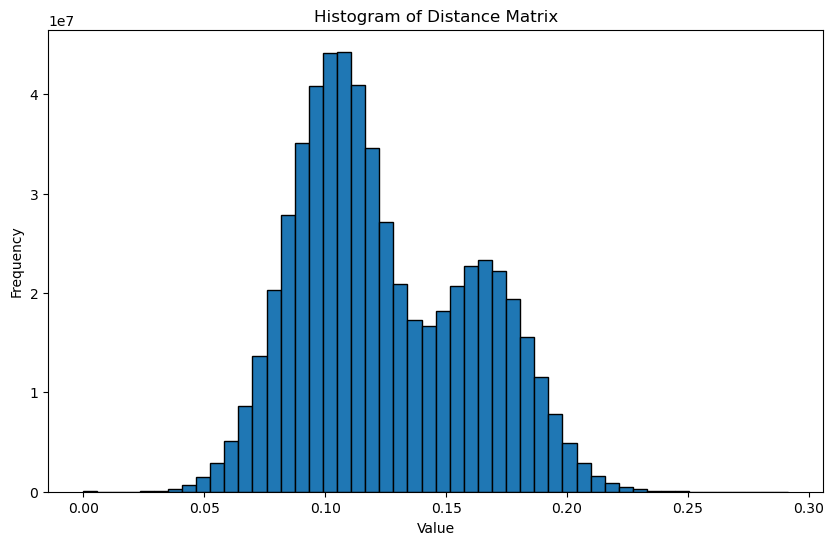

In [41]:
plot_histogram(distance_matrix, bins=50)

adj_path = generate_file_path("data/Dist_matrix("+32469+").npy")
adj = np.load(adj_path)

## MST

In [43]:
distance_matrix_mst = compute_mst_distance_matrix(distance_matrix)

Starting the computation of the minimum spanning tree...
Minimum spanning tree computed. Converting to dense matrix...
Conversion complete. Returning MST distance matrix.


In [47]:
distance_matrix_mst.max()

0.12845343

## Data Segment

In [62]:
train_pos_indices, train_neg_indices, val_indices, test_indices = split_dataset(
    df_sample)

In [66]:
print(len(train_pos_indices)+len(train_neg_indices))
print(len(val_indices))
print(len(test_indices))

14400
4800
4800


## Melted List (Set of Edges)

In [72]:
melt_list_pos = melt_matrix(distance_matrix=distance_matrix_mst,
                            keep_rows=list(range(
                                distance_matrix_mst.shape[0])),
                            keep_columns=train_pos_indices)

In [73]:
melt_list_neg = melt_matrix(distance_matrix=distance_matrix_mst,
                            keep_rows=list(range(
                                distance_matrix_mst.shape[0])),
                            keep_columns=train_neg_indices)

In [75]:
len(melt_list_pos)

129312000

In [79]:
distance_matrix_mst.shape[0] * len(train_pos_indices)

129312000

In [77]:
len(melt_list_neg)

216288000

In [80]:
distance_matrix_mst.shape[0] * len(train_neg_indices)

216288000

## Centrality Measures Calculation

In [ ]:
centrality_pos = compute_centrality_measures(melt_list_pos)

In [ ]:
centrality_neg = compute_centrality_measures(melt_list_neg)